# OpFlow codomain 2D TGRF data experiment

In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.fft
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## Dataset

In [3]:
def truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=-4, ub=4, nchannel=2):
    # temp_x_train = [ndim*ndim, ntrain, nchannel=1]
    ntrain = int(ntrain*nchannel)
    
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds=(1e-1, 10.0), nu=nu_x)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    #y_mean, y_std = gpr_model.predict(X, return_std=True)

    x_train = []
    samples = 0
    
    while samples < ntrain:
        temp_x_train = torch.Tensor(gpr_model.sample_y(X, ntrain, random_state=None)[:,:,np.newaxis])
        # 
        logic_value = (temp_x_train <= ub) & (temp_x_train >= lb)
        pass_id = torch.all(logic_value, axis=0)
        
        n_generated = temp_x_train[:,pass_id].shape[1]
        if n_generated > 0:
            samples += n_generated
            
            x_train.append(temp_x_train[:, pass_id])
            print("finished {}/{} ".format(samples, ntrain))
    
    x_train = torch.cat(x_train, dim=1)
    x_train = x_train[:,:ntrain]
    if nchannel == 2:
        return torch.cat([x_train[:, :ntrain//2, None], x_train[:, ntrain//2:, None]], dim=-1)
    else:
        return x_train[:,:,None]

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means


In [5]:
def autocovariance_2d(data):
    """
    Calculate the auto-covariance of a 2D dataset using FFT.

    Parameters:
    data (torch.Tensor): A 3D tensor of shape (N, m, m) where N is the number of samples and
                         each sample is an m by m matrix.

    Returns:
    torch.Tensor: Auto-covariance matrix of the 2D dataset.
    """
    N, m, _ = data.shape
    
    # Demean the data
    data_demeaned = data - data.mean(dim=(1, 2), keepdim=True)
    
    # Apply FFT to each 2D sample
    fft_data = torch.fft.fft2(data_demeaned)
    
    # Use the Wiener-Khinchin theorem: the auto-covariance can be obtained by the inverse FFT of the power spectrum
    power_spectrum = fft_data * torch.conj(fft_data)
    autocov = torch.fft.ifft2(power_spectrum).real
    
    # Normalize by the number of samples to get the average auto-covariance
    autocov /= N
    
    # Since the result includes autocovariance at different lags, we take the autocovariance at lag 0
    # which is located at the center of the matrix
    autocov_at_lag0 = autocov[:, m//2, m//2]
    
    return autocov_at_lag0

Auto-covariance matrix calculated using FFT:
tensor([-0.1180,  0.1998, -0.3714, -0.2402,  0.0571, -0.0408,  0.2598, -0.0062,
        -1.0658, -0.4894])


### dataset parameters and preparation

In [6]:
ntrain = 12000
nchannel = 2
ndim = 64
batch_size = 128

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.2
nu_z = 1.5

lb = -2
ub = 2

Starting up. Generate GRF samples
(4096, 2)
finished 11544/24000 
finished 23116/24000 
finished 34645/24000 
(4096, 2)


/home/yshi5/miniconda3/envs/OpFlow/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


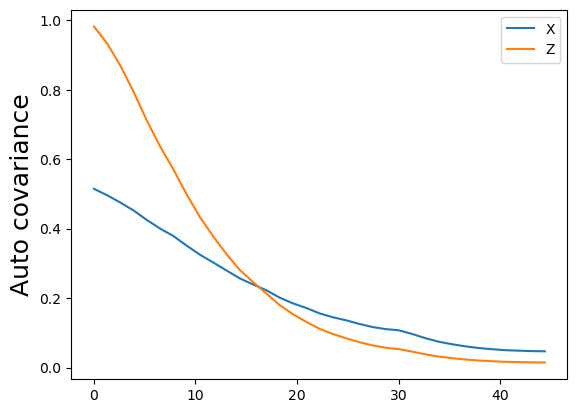

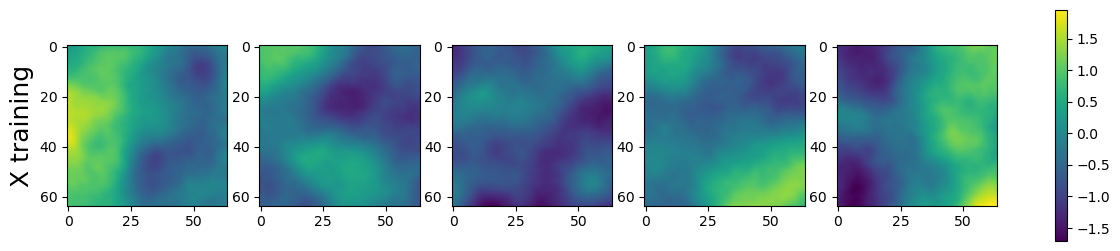

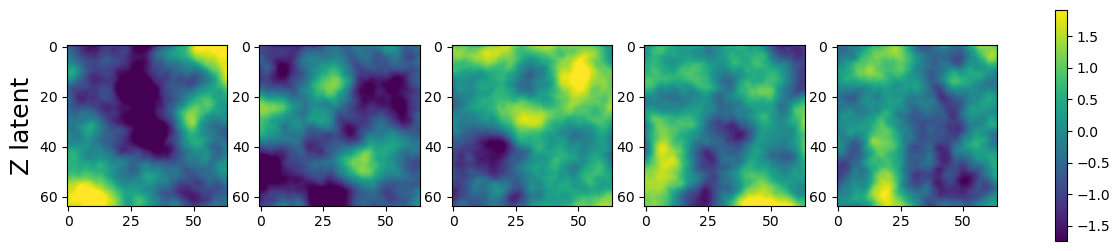

In [7]:
print("Starting up. Generate GRF samples")
import statsmodels.api as sm

np.random.seed(22)

#x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=lb, ub=ub, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

## Model

In [8]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [9]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        #print("FNO x shape:{}".format(x.shape))
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [10]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [11]:
class AffineCoupling(nn.Module):
    def __init__(self, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        #self.coupling = UNO_2D(3, width=width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        x = z
        #print("x shape:{}", x.shape)
        x, log_actnorm = self.actnorm(x)
        
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,:,0:1]
        x2 = x[:,:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], x.shape[2], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,:,0:1]
        z2 = z[:,:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], z.shape[2], 2]).shape)
        log_scale = scale_shift[:,:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [12]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []

        self.bijectors = nn.ModuleList([
            AffineCoupling( width=width) for i in range(blocks)
        ])
        #self.mapping_z = FNO2d(modes, modes, width)
        
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size, ndim = x.shape[0], x.shape[1]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return z, log_pz/batch_size, sum(log_dets)/batch_size
        
    def inverse(self, z):
        
        ndim = z.shape[1]

        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [13]:
lr = 5*1e-5
epochs = 400
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

#width = 32
width = 64
blocks = 8

base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [14]:
G = OpFlow(width=width, blocks=blocks, base_dist=base_dist).to(device)

#D = DDP(D, device_ids=device_ids, output_device=0) #data parallel
#G = DDP(D, device_ids=device_ids, output_device=0)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

Number generator parameters:  67312688


In [15]:
G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
#G_scheduler = torch.optim.lr_scheduler.StepLR(G_optim, step_size=200, gamma=0.2)

G.train()

OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=64, bias=True)
        (conv0): SpectralConv2d()
        (conv1): SpectralConv2d()
        (conv2): SpectralConv2d()
        (conv3): SpectralConv2d()
        (w0): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w1): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w2): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (w3): pointwise_op(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=64, bias=True)
 

# Model Training

In [16]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # usually, use should use small factor of noise
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [17]:
def is_psd(mat):
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())


def matrix_sqrt(matrix):
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z_all, base_mu, base_cov):
    """
    z : [n, ndim, 2*ndim, 1]
    base_mu : [2*ndim*ndim]
    base_cov : [2*ndim*ndim, 2*ndim*ndim]
    """
    F2ID_all = 0
    for i in range(2):
        z = z_all[:,:,:,i]
        ndim = z.shape[1]
        syn_mu = z.mean(dim=0).reshape(ndim*ndim)
        syn_cov = torch.cov(z.reshape(-1, ndim*ndim).permute(1,0))

        """
        #print("syn_mu shape: {}, syn_cov shape : {}".format(syn_mu.shape, syn_cov.shape))

        if base_cov_sqrt is None:
            base_cov_sqrt = matrix_sqrt(base_cov).detach()

        #print("device of syn_cov :{}, base_cov:{}, syn_cov :{}, base_cov_sqrt:{}".format(syn_cov.device, base_cov.device, syn_cov.device, base_cov_sqrt.device))
        #L = syn_cov + base_cov - 2 * matrix_sqrt(base_cov_sqrt @ syn_cov @ base_cov_sqrt).cuda()
        #term1 = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim)
        #term2 = torch.trace(L)/(ndim*ndim)
        #F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.trace(L)/(ndim*ndim)    
        """

        F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.sum((syn_cov -base_cov)**2)/(ndim*ndim)
        if i == 0:
            term1 = F2ID
        if i == 1:
            term2 = F2ID
        F2ID_all += F2ID
        #print('term1 : {}, term2 :{}'.format(term1, term2))
    return F2ID_all, term1, term2

In [18]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, scheduler=None, fine_tune_epoch=50):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)
    
    epochs = epochs+fine_tune_epoch
    # record the loss information
    losses_G = np.zeros(epochs)

    for epoch in range(epochs):

        loss_G = 0.0
        # fine tune phase
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1
            
        for j in range(n_train_tot):
           
            G_optim.zero_grad()
            x = get_x_batch().to(device)
            z_syn, log_pz, log_det = G(x)            
    
            ll_loss = (-log_pz - log_det).mean()
           
            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss, term1, term2 = cal_F2ID(z_syn, base_mu, base_cov)
                loss = ll_loss + reg_fac*F2ID_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.2f}, loss_F2ID:{:.2f}, loss_F2ID term1:{:.2f}, loss_F2ID term2:{:.2f}".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item(), term1.item(), term2.item()))
            
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
            
            #loss = -torch.mean(D(x_syn))
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
                     
        with torch.no_grad():
            nplot = 5
            
            fig, ax = plt.subplots(2,nplot, figsize=(15,6))
            Z_alt = torch.cat([base_dist.rsample(sample_shape=(256,)).reshape(-1, ndim, ndim, 1), 
                               base_dist.rsample(sample_shape=(256,)).reshape(-1, ndim, ndim, 1)], axis=-1)           
            
            X_alt = G.inverse(Z_alt)
            X_alt = X_alt.detach().cpu()
            lags, acf1 = compute_acovf(X_alt[:,:,:,0])
            lags, acf2 = compute_acovf(X_alt[:,:,:,1]) 
            
            for i in range(nplot-1):
                bar = ax[0,i].imshow(X_alt[i,:,:,0], vmin=-2, vmax=2)
                plt.colorbar(bar, ax=ax[0,i])

                bar = ax[1,i].imshow(X_alt[i,:,:,1], vmin=-2, vmax=2)
                plt.colorbar(bar, ax=ax[1,i])
            ax[0,nplot-1].plot(x_distance, x_acovf_mean, color='k', label='Ground Truth')
            ax[0,nplot-1].plot(lags, acf1, color='r', label='Synthetic channel_0')
            ax[0,nplot-1].legend(loc='upper right')      
            
            ax[1,nplot-1].plot(x_distance, x_acovf_mean, color='k', label='Ground Truth')
            ax[1,nplot-1].plot(lags, acf2, color='r', label='Synthetic channel_1')
            ax[1,nplot-1].legend(loc='upper right')  
            
            plt.savefig("../paper_plots/{}/2D_codomain_{}_set1.pdf".format(folder, epoch))
            plt.close()
            
            
            
        losses_G[epoch] = loss_G / batch_size
        losses_G_val[epoch] = loss_G_val / batch_size
        losses_W[epoch] = loss_W / batch_size
        
        #D_scheduler.step()
        #G_scheduler.step()
        if ((epoch+1)%100 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "../paper_saved_models/{}/2D_codomain_{}_set1.pt".format(folder, epoch))
        
    return losses_G

In [19]:
folder = "GRF2TruncatedGRF_FNO_codomain_64x64_set1"
if not os.path.exists(f"../paper_saved_models/{folder}"):
    os.makedirs(f"../paper_saved_models/{folder}")
if not os.path.exists(f"../paper_plots/{folder}"):
    os.makedirs(f"../paper_plots/{folder}")

In [ ]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

## Validation

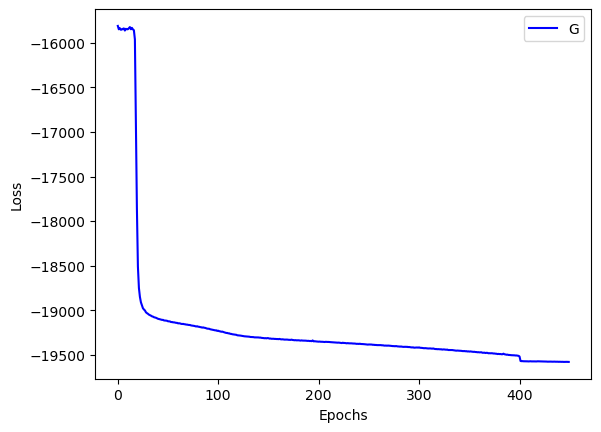

In [41]:
plt.plot( losses_G, c='b', label='G')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Testing and Debug (Optional)

In [ ]:
folder = "GRF2TruncatedGRF_FNO_codomain_64x64_set1"
if not os.path.exists(f"../paper_pdf/{folder}"):
    os.makedirs(f"../paper_pdf/{folder}")

In [14]:
G = OpFlow(width=width, blocks=blocks, base_dist=base_dist).to(device)

model_path = f"../paper_saved_models/{folder}/2D_codomain_399_set1.pt"
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
model = G

### check other statistics

In [16]:
x_train_raw, _, _ = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=True, nchannel=1)
x_train_raw = x_train_raw.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
## calculate the statistics 
_, x_acovf_raw = compute_acovf(x_train_raw[:,:,:,0])
x_hist_raw, bin_edges = x_train_raw.histogram(range=[-5.5,5.5], density=True)

(4096, 2)


In [17]:
x_pos = x_distance/ndim
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
_, x_acovf_true = compute_acovf(x_train[:,:,:,0].squeeze())

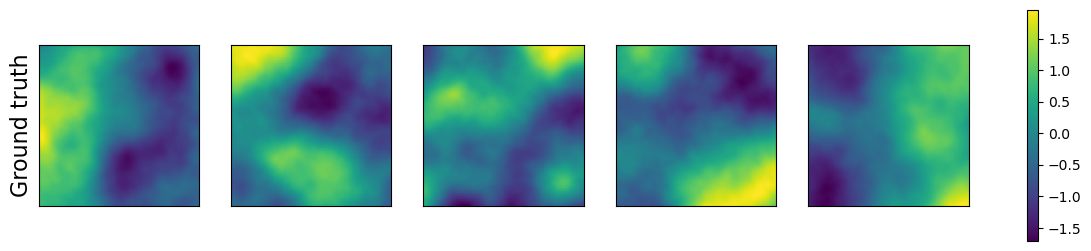

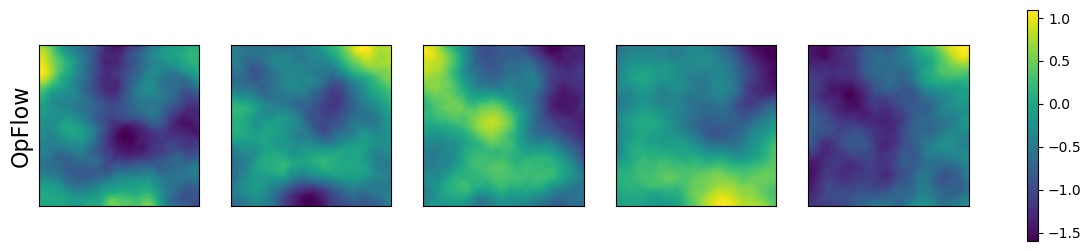

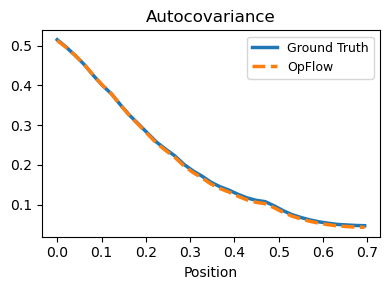

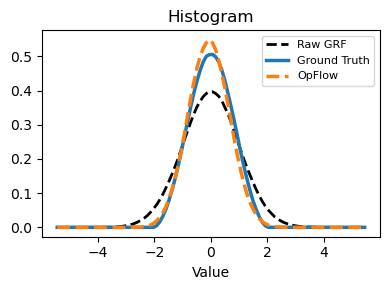

In [19]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    Z = z_train[:5].to(device)
            
    X_hat = model.inverse(Z).detach().cpu()
    
    X_hat_channel1 = X_hat[:,:,:,0]
    X_hat_channel2 = X_hat[:,:,:,1]
    X_hat = X_hat.permute(0, 3, 1, 2).reshape(-1, ndim, ndim).numpy()
    X_ground_truth = x_train[:5,:,:,0]
    # plot
    
    z_train_iter = torch.split(z_train[:5000], 1000, dim=0)
    
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
            
    X_alt = torch.vstack(X_alt) 
    
    X_alt_channel1 = X_alt[:,:,:,0]
    X_alt_channel2 = X_alt[:,:,:,1]
    X_alt = X_alt.permute(0, 3, 1, 2).reshape(-1, ndim, ndim)
    #X_alt = (X_alt - X_alt.mean())/X_alt.std()
    
    _, x_acovf_channel1 = compute_acovf(X_alt_channel1.squeeze())
    _, x_acovf_channel2 = compute_acovf(X_alt_channel2.squeeze())

    #x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
    # when the value ranges the same, bin_edges the same
    x_hist_channel1, bin_edges_alt = X_alt_channel1.histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt_channel2.histogram(range=[-5.5,5.5], density=True)    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('Ground truth', fontsize=16)
            
    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"../paper_pdf/{folder}/{folder}_sample_ground_truth.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel1[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
        if i == 0:
            ax[i].set_ylabel('OpFlow', fontsize=16)
            
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")
    

    """
    #plt.show()
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel2[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
     
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")    
    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.plot(x_pos, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel2')
    
    #ax[0].set_ylim(0,1.1)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_raw,  c='k', lw=2, ls='--', label='Raw GRF')
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')

    ax.set_title('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_statistic.pdf")


# 2D super-resolution

(16384, 2)
finished 4802/10000 
finished 9565/10000 
finished 14388/10000 
(16384, 2)


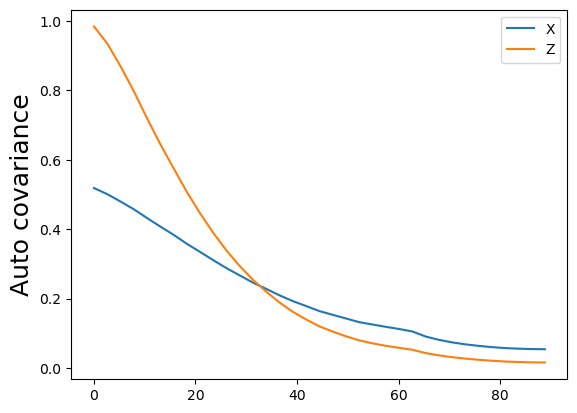

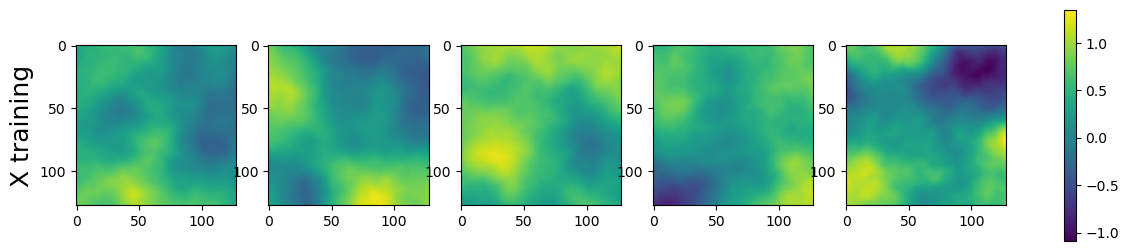

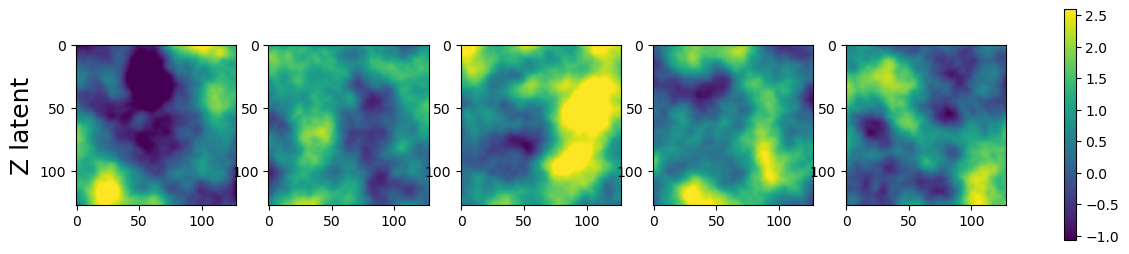

In [20]:

ntrain_sup = 5000
#x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = truncatedGRF(ndim*2, length_scale_x, nu_x, ntrain_sup, lb=lb, ub=ub, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, 2*ndim, 2*ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim*2, length_scale_z, nu_z, ntrain_sup, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, 2*ndim, 2*ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

In [21]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/(2*ndim)
_, x_acovf_true = compute_acovf(x_train[:,:,:,0].squeeze())

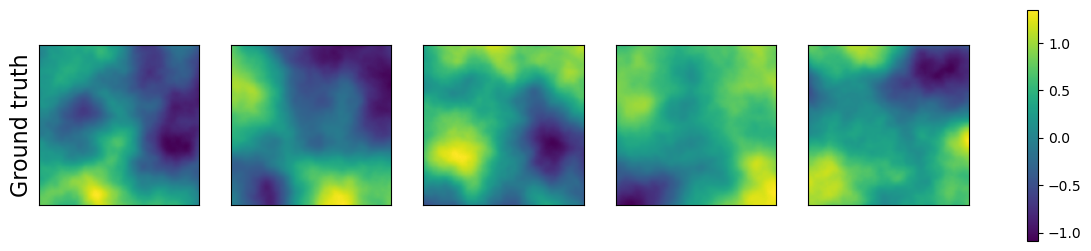

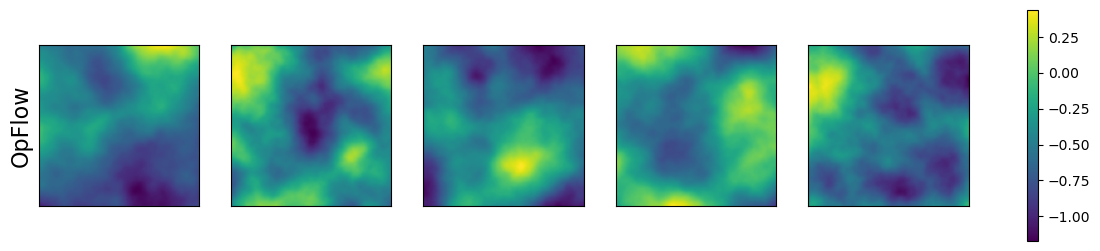

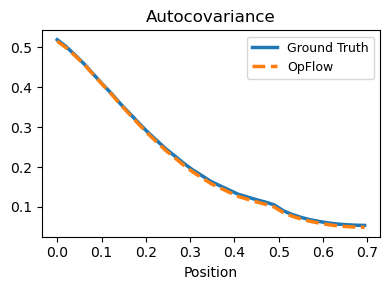

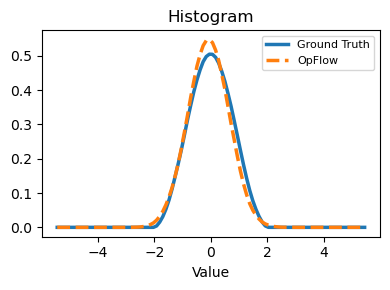

In [23]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    Z = z_train[:5].to(device)
            
    X_hat = model.inverse(Z).detach().cpu()
    
    X_hat_channel1 = X_hat[:,:,:,0]
    X_hat_channel2 = X_hat[:,:,:,1]
    X_hat = X_hat.permute(0, 3, 1, 2).reshape(-1, 2*ndim, 2*ndim).numpy()
    X_ground_truth = x_train[:5,:,:,0]
    # plot
    
    z_train_iter = torch.split(z_train[:5000], 500, dim=0)
    
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt) 
    
    X_alt_channel1 = X_alt[:,:,:,0]
    X_alt_channel2 = X_alt[:,:,:,1]
    X_alt = X_alt.permute(0, 3, 1, 2).reshape(-1, 2*ndim, 2*ndim)
    #X_alt = (X_alt - X_alt.mean())/X_alt.std()
    
    _, x_acovf_channel1 = compute_acovf(X_alt_channel1.squeeze())
    _, x_acovf_channel2 = compute_acovf(X_alt_channel2.squeeze())

    #x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
    # when the value ranges the same, bin_edges the same
    x_hist_channel1, bin_edges_alt = X_alt_channel1.histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt_channel2.histogram(range=[-5.5,5.5], density=True)    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('Ground truth', fontsize=16)
            
    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"../paper_pdf/{folder}/{folder}_sample_ground_truth_sup.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel1[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
        if i == 0:
            ax[i].set_ylabel('OpFlow', fontsize=16)
            
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)
    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel1_sup.pdf")
    

    """
    #plt.show()
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat_channel2[i,:,:].squeeze()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(x)
     
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples_channel2_sup.pdf")    
    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.plot(x_pos, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel2')
    
    #ax[0].set_ylim(0,1.1)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov_sup.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')

    ax.set_title('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_statistic_super.pdf")
